# Qiskit Notebook 8 - Qiskit Runtime and QAOA


In this Notebook, we will learn about:

* Qiskit Runtime
* Quantum Approximate Optimization Algorithm (QAOA)

In [ ]:
# If using Google Colab, uncomment the following

#!pip install -q qiskit=1.3.4
#!pip install -q qiskit[visualization]
#!pip install -q qiskit-ibm-runtime==0.34.0
#!pip install -q qiskit-aer==0.16.0
#!pip install -q rustworkx
#!pip install -q h5py

**Observation: This Notebook requires you to execute your own Jobs using your IBM Quantum Account.**

# IBM Quantum Channel Account

We can access IBM quantum processing units (QPUs) through the IBM Quantum Platform channel. Channel is the term used to describe the method you use to access IBM Quantum services. In our case, we will access with an Open Plan  (free account), which allows us to run quantum circuits for free, up to 10 minutes quantum time per month (resets at 00:00 UTC on the first day of each month).

Observation: From 1st of July 2025 onwards, accessing the IBM Quantum Platform will require an [IBM Cloud account](https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp).


After creating an account on the IBM Quantum Platform, we need to retrieve our API token and save our credentials locally. We only have to do this once.

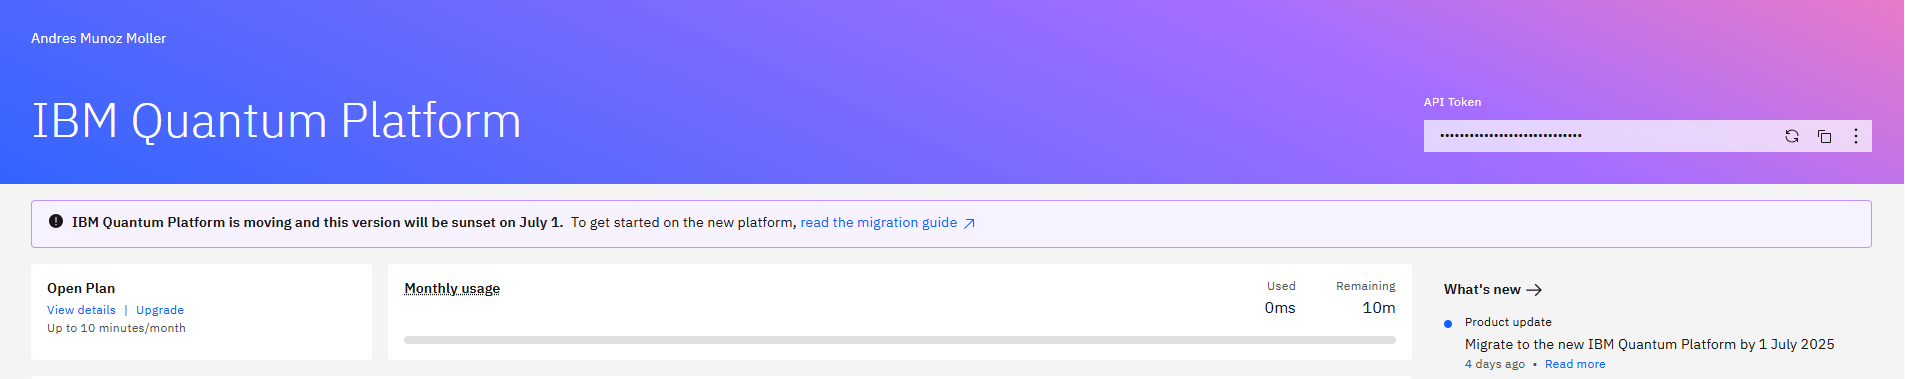

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

#token = "<your-token>"

#QiskitRuntimeService.save_account(
#  token=token,
#  channel="ibm_quantum",
#  overwrite=True)

# Load saved credentials
service = QiskitRuntimeService()

We can check to which QPUs we have access with our account through the `service.backends()` method, or by directly checking our IBM Quantum Platform. Not only that, we can check which QPU is the least busy through the `service.least_busy()` method.

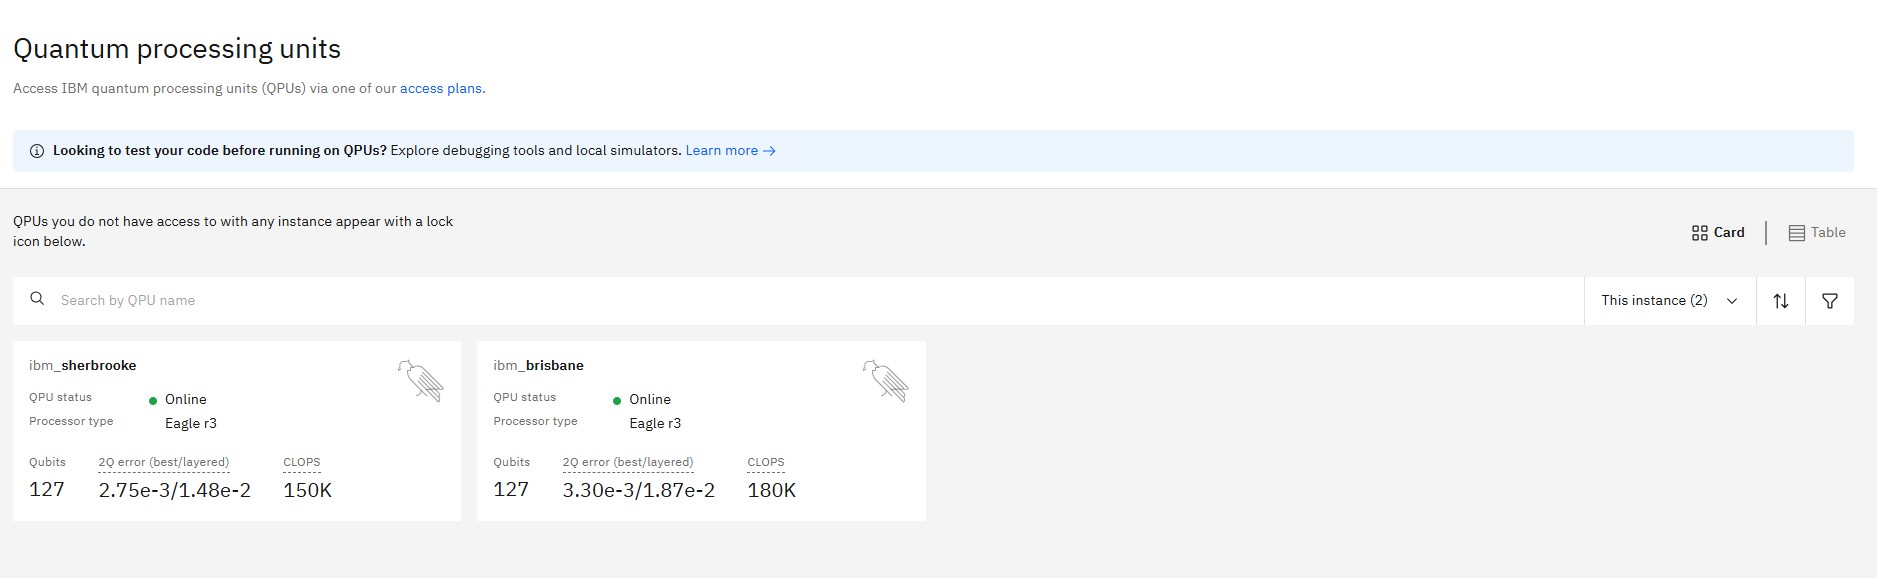

In [ ]:
print(service.backends())
print(service.least_busy(operational=True))

# Qiskit Runtime

Qiskit Runtime is a cloud-based service for executing quantum computations on IBM Quantum hardware, accessed through the `qiskit-ibm-runtime` package. The Qiskit Runtime service streamlines quantum computations and provides optimal implementations of the Qiskit primitives for IBM Quantum hardware. Qiskit Runtime also include fake backends, which mimic the behaviors of IBM QPUs by using QPU snapshots. To execute circuits in a QPU, we use the Qiskit Runtime own primitive Sampler and Estimator classes.

In [ ]:
backend = service.least_busy(operational=True)
print(backend)

## Job Execution

The **Job** execution mode corresponds to a single primitive request of the estimator or the sampler made without a context manager. Circuits and inputs are packaged as primitive unified blocs (pubs) and submitted as an execution task on the quantum computer. To run in job mode, we specify `mode=backend` when instantiating a primitive.

As an example, let us consider a the same $GHZ$ state of $5$ qubits from Notebook 6.

$$| GHZ_5 \rangle = \frac{1}{\sqrt{2}} \left(| 00000 \rangle + | 11111 \rangle  \right)$$

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as SamplerRuntime

sampler = SamplerRuntime(mode=backend)

In [ ]:
from qiskit import QuantumCircuit

qc_ghz5 = QuantumCircuit(5)
qc_ghz5.h(0)
qc_ghz5.cx(0, 1)
qc_ghz5.cx(1, 2)
qc_ghz5.cx(2, 3)
qc_ghz5.cx(3, 4)
qc_ghz5.measure_all()
qc_ghz5.draw("mpl")

To obtain the required ISA circuit, we need to transpile our circuit. We will construct our pub considering $500$ shots.

In [ ]:
from qiskit.transpiler import generate_preset_pass_manager

# Transpile to get a ISA circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_ghz5_trans = pm.run(qc_ghz5)     

shots = 500

pub = (qc_ghz5_trans, [], shots)

Compared to executing a circuit in local simulator, a job that is sent to a real QPU takes time, as execution time is shared between users. Therefore, upon running a job, it gets sent into a queue and we retrieve the results once the job finishes. We can check the job status through the following methods:

* `job.job_id()`: Return the ID that uniquely identifies that job. Retrieving the job results at a later time requires the job ID. Therefore, it is recommended that you save the IDs of jobs you might want to retrieve later.
* `job.status()` : Check the job status.
* `job.result()` : Review job results immediately after the job completes.

We can also retrieve a job that was previously submitted with the `service.job('ID')` method, specifying the corresponding ID of the job. Finally, once a job is submitted, we can get an estimation for how much quantum time the job will take to run by using `job.usage_estimation`.

In [ ]:
# Comment or uncomment depending on whether you want to run the circuit or retrieve a job


# Run the circuit using the sampler
# job = sampler.run([pub])


# Retrieve Job from ID
job = service.job('ID')

In [ ]:
# Get the job ID

job.job_id()

In [ ]:
# Print the job status

job.status()

In [ ]:
# Quantum time usage estimation

job.usage_estimation

In [ ]:
# Once the job is completed, we can retrieve the results

result = job.result()

pub_result = result[0]
counts = pub_result.data.meas.get_counts()
counts

We can also use Qiskit Runtimes primitives together with the Aer simulator for local testing, that is, for verifying our program before sending it to the QPU.

In [ ]:
from qiskit_aer import AerSimulator

backend_aer = AerSimulator()
pm_sim = generate_preset_pass_manager(backend=backend_aer)
qc_trans_sim = pm_sim.run(qc_ghz5) 

pub_sim = (qc_trans_sim, [], shots)

sampler_sim = SamplerRuntime(mode=backend_aer)
job_sim = sampler_sim.run([pub_sim])
result_sim = job_sim.result()
pub_result_sim = result_sim[0]
counts_sim = pub_result_sim.data.meas.get_counts()

In [ ]:
from qiskit.visualization import plot_histogram


legend = ['Exp Counts', 'Sim Counts']
plot_histogram([counts, counts_sim], legend=legend)

The ID of a job can also be obtained from the IBM Quantum Platform.

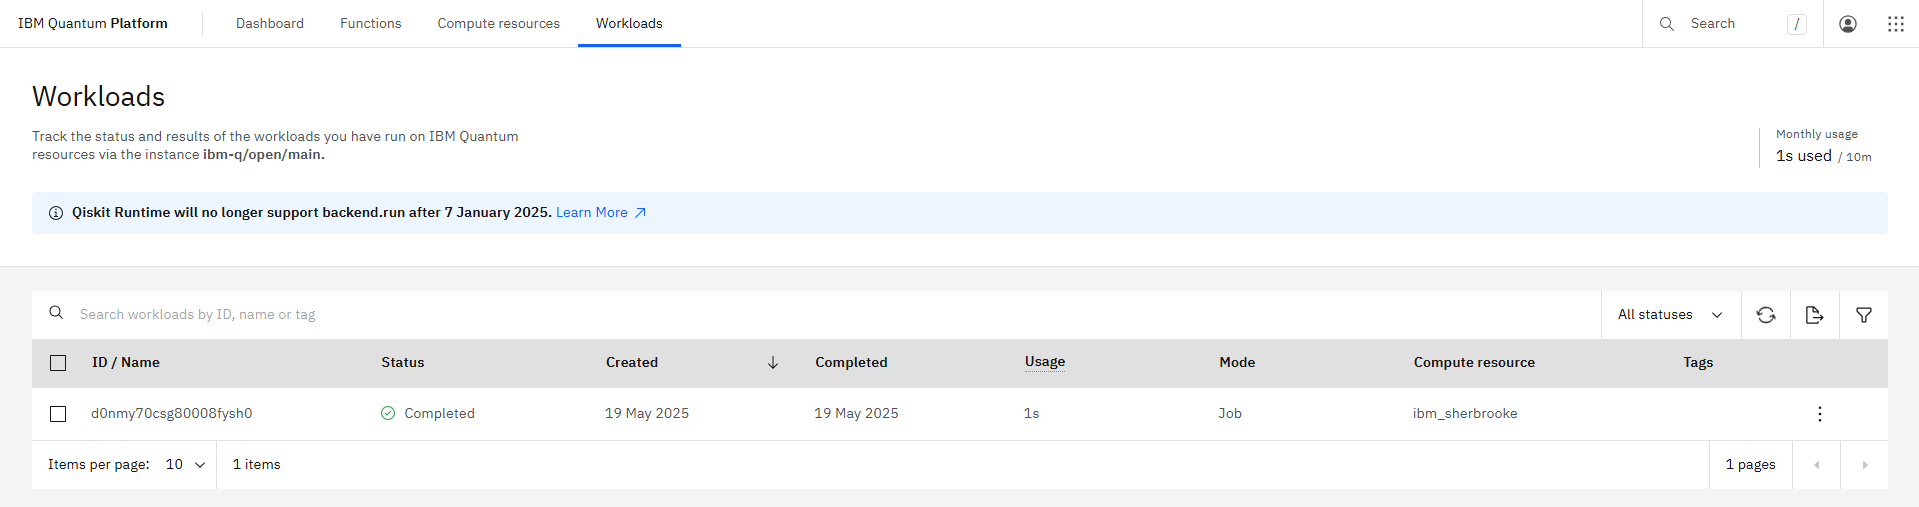

## Batch Execution

The **Batch** execution mode corresponds to a multi-job manager for efficiently running experiments comprising multi-job workloads. These workloads are made up of **independently executable jobs** that have no conditional relationship with each other. With batch mode, we can submit all out jobs **at once**. The system parallelizes or threads the pre-processing step of each primitive job to more tightly package quantum execution across jobs, and then runs the quantum execution of each job in quick succession to deliver the most efficient results.

Observation 1: The jobs are not guaranteed to run **in the order they are submitted**.

Observation 2: While your batch jobs will run as closely together as possible, they **do not get exclusive access to the backend**: they might run in parallel with other users' jobs if there is enough processing capacity on the QPU. Additionally, QPU calibration jobs could run between the batched jobs.

Observation 3: Open Plan users can have **no more than three jobs** running and/or in the queue (across all quantum computers) at the same time.

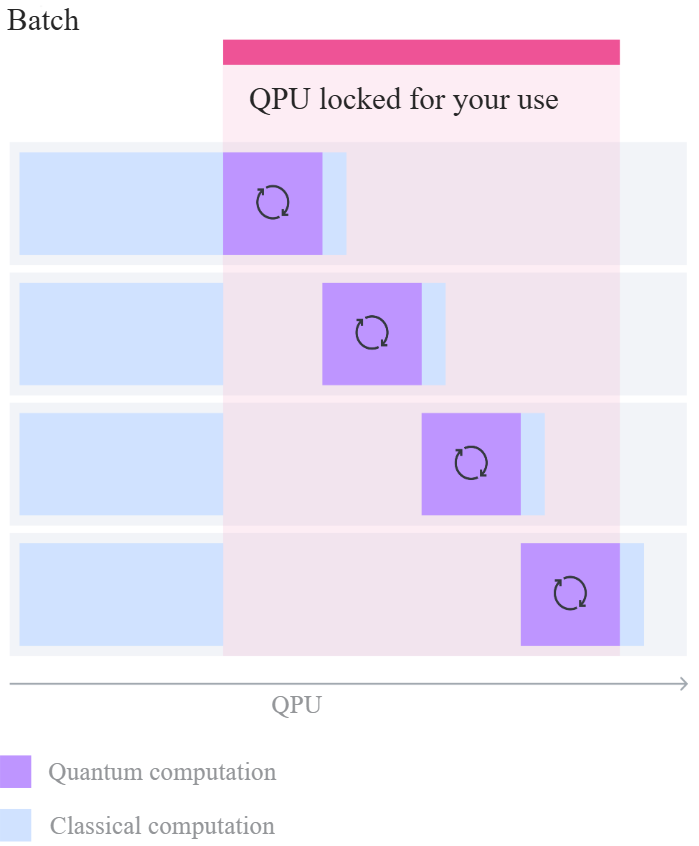

Let us consider five circuits that we want to run in parallel in the Batch mode. The `ZZFeatureMap` prepares circuits used in Quantum Machine Learning (QML) methods to encode training data into parameterized circuits.

In [ ]:
from qiskit.circuit.library import zz_feature_map

zz_feature_map = zz_feature_map(feature_dimension=2, reps=2)
zz_feature_map.draw("mpl")

In [ ]:
import numpy as np

# Define five sets of parameters
n_qubits = zz_feature_map.num_qubits
n_params = zz_feature_map.num_parameters
params = np.random.rand(n_params, 5)


# Get ISA circuit

zz_circ = QuantumCircuit(n_qubits)
zz_circ.compose(zz_feature_map, inplace=True)
zz_circ.measure_all()

zz_circ_trans = pm.run(zz_circ)


# Create a list of pubs
shots = 300
pubs = []

for i in range(5):
    pub_i = (zz_circ_trans, params[:, i], shots)
    print(pub_i)
    pubs.append(pub_i)

To run our workload using the Batch method, we have two options:

* Using the `Batch` class, where we manually open the batch, initialize the jobs that will be executed in parallel within the batch, and then manually close the batch to avoid accepting new jobs (and thus surpassing the batch maximum time execution).

* Using the context manager `with Batch(...)`, which automatically opens and closes the batch.


The batch's maximum **time to live** (TTL) can be specified with the `max_time` parameter. This should exceed the longest job's execution time. This timer starts when the batch starts, and when the value is reached, the batch is closed. Any jobs that are running will finish, but jobs still queued are cancelled. By default, Open Plan users have a maximum TTL of 10 minutes.

Similarly to jobs, we can get an overview of a batch's configuration and status (including usage time) with the `batch.details()` method.

In [ ]:
from qiskit_ibm_runtime import Batch

# Comment or uncomment depending on whether you want to run the batch or retrieve the jobs


# In Batch mode, we do not specify the primitive mode, otherwise it will be run in Job mode!


# jobs_batch = []

# with Batch(backend=backend, max_time="10m") as batch:
#     sampler = SamplerRuntime()
#     for pub_i in pubs:
#         job_i = sampler.run([pub_i])
#         jobs_batch.append(job_i)

# We get a warning, as our plan only allows 3 jobs at a time

In [ ]:
#print(batch.details())

In [ ]:
# Get the job IDs

# IDS = []
# for job_i in jobs_batch:
#     print(job_i.job_id())
#     IDS.append(job_i.job_id())

# Retrieve the jobs from the batch

IDS = [
 'ID1',
 'ID2',
 'ID3',
 'ID4',
 'ID5']

jobs_batch = []
for id in IDS:
    job_i = service.job(id)
    jobs_batch.append(job_i)

In [ ]:
jobs_batch

In [ ]:
# Check if all jobs are completed
for job_i in jobs_batch:
    print(job_i.status())

In [ ]:
legend = [f'Params {i}' for i in range(5)]
counts = [job_i.result()[0].data.meas.get_counts() for job_i in jobs_batch]

plot_histogram(counts, legend=legend)

## Session Execution

The **Session** execution mode corresponds to a **dedicated window** for running a multi-job workload. During this window, the user has exclusive access of the system i.e. QPU and no other jobs can run - including calibration jobs. This allows users to experiment with variational algorithms in a more predictable way and even run multiple experiments simultaneously, taking advantage of parallelism in the stack. Similarly to the Batch execution mode, using sessions help us avoid delays caused by queuing each job separately.

Observation: **Open Plan users cannot submit session jobs - jobs will run in Job mode instead.**

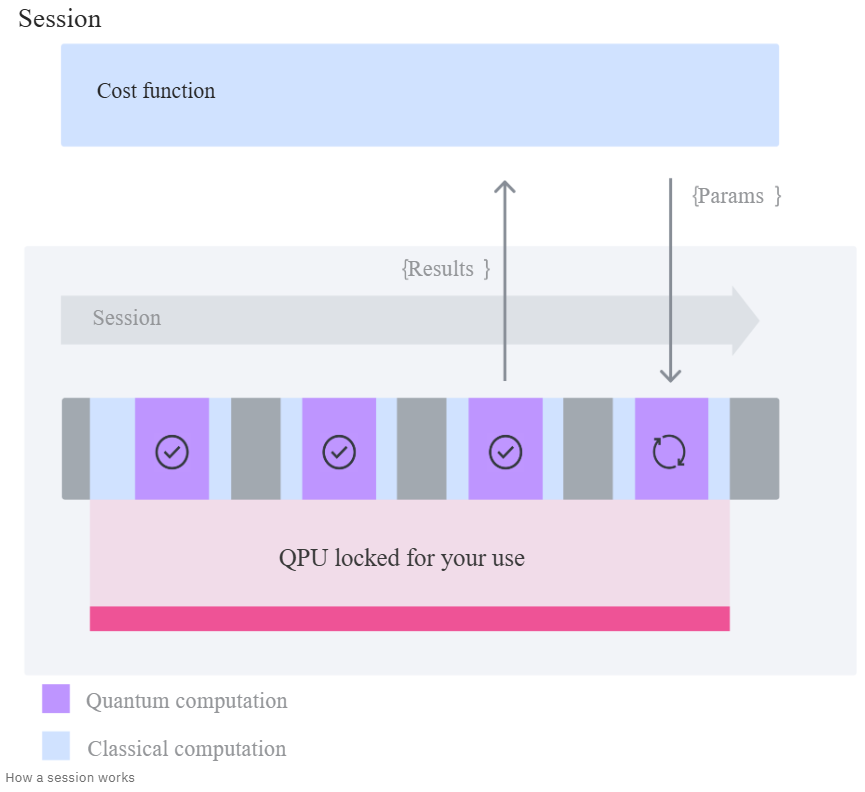

In [ ]:
#DO NOT RUN: EXAMPLE CODE

#from qiskit_ibm_runtime import Session, EstimatorV2 as EstimatorRuntime
#from scipy.optimize import minimize

# ansatz = zz_feature_map(2,2)
# hamiltonian = "ZZ"

#def cost_func(params, ansatz, hamiltonian, estimator):
    # Return estimate of energy from estimator
 
#    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
#    return energy
 
#num_params = ansatz.num_parameters
#x0 = 2 * np.pi * np.random.random(num_params)
 
#with Session(backend=backend) as session:
#    estimator = EstimatorRuntime()
#    res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="cobyla")


# Quantum Approximate Optimization Algorithm (QAOA)


The **Quantum Approximate Optimization Algorithm** (QAOA) corresponds to a variational quantum algorithm (inspired by quantum annealing) for solving combinatorial optimization methods on NISQ devices. QAOA uses an unitary operation $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$, characterized by the parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$, which prepares a quantum state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$, with the goal to maximize a cost function $F_p(\boldsymbol{\gamma},\boldsymbol{\beta})$ which represents the combinatorial problem.

The unitary operation $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ is made of two unitary operations:

* $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$, where $H_B$ corresponds to the *mixer* Hamiltonian.
* $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_C}$, where $H_C$ corresponds to the *cost* Hamiltonian, which encodes the solution to the optimization problem.

In general, $H_B$ is made up of sums of single qubit Pauli $X$ gates, given by

$$ H_B = \sum_{i = 1}^n X_i,$$

whereas $H_C$ corresponds to a Hamiltonian that is diagonal in the computational (Pauli $Z$) basis, and has at most $m$ local elements $\hat{C}_k$, 

$$ H_C = \sum_{k = 1}^m \hat{C}_k = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x|, \quad x \in \{0,1\}^n .$$

The objective state (or QAOA ansatz in the description of VQA) is prepared by applying these unitary operations in alternating blocks $p$ times

$$
\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) 
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} 
\lvert \psi_0 \rangle = e^{ -i\beta_p H_B } e^{ -i\gamma_p H_C } \ldots e^{ -i\beta_1 H_B } e^{ -i\gamma_1 H_C } \lvert \psi_0 \rangle 
$$

where $\lvert \psi_0 \rangle$ is a convenient initial state corresponding to the ground state of the mixer Hamiltonian, which in this case corresponds to the uniform superposition of all computational basis states $|+\rangle^{\otimes n} = \bigg[\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg]^{\otimes n}$.

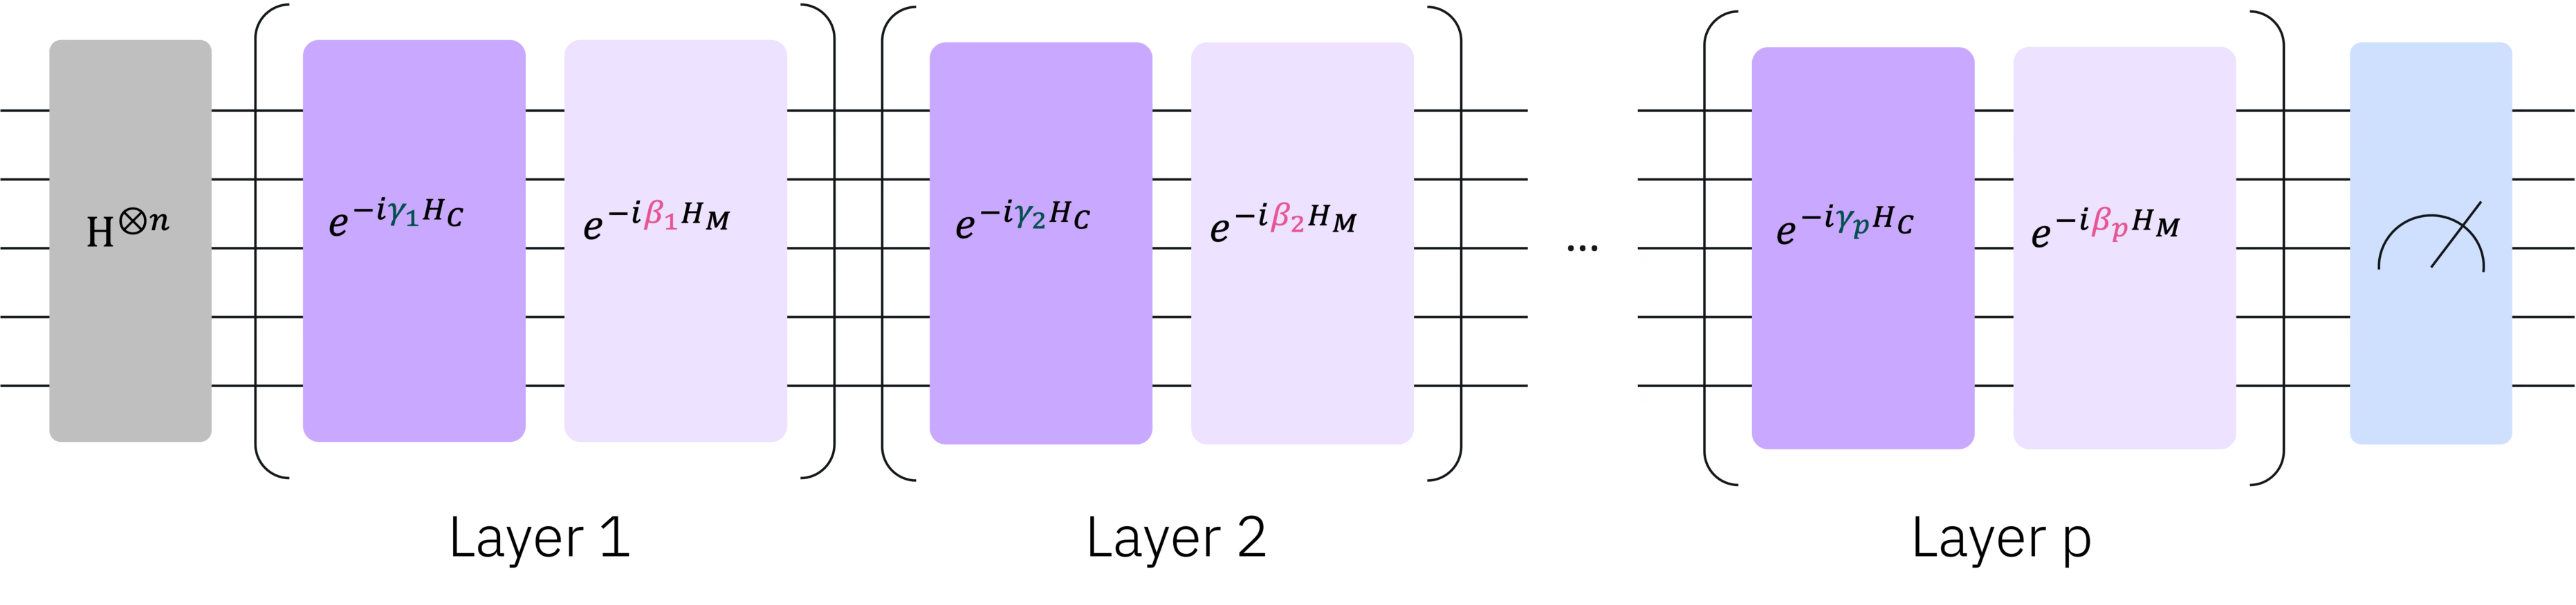

The objective of the algorithm is to find the optimal parameters $(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt})$ such that the quantum state $\lvert \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle$ codifies the solution to the problem, which corresponds to maximizing the cost function


$$F_p(\boldsymbol{\gamma},\boldsymbol{\beta}) = \langle \psi_p(\boldsymbol{\gamma},\boldsymbol{\beta})|H_C|\psi_p(\boldsymbol{\gamma},\boldsymbol{\beta})\rangle= \sum_{x \in \{0,1\}^n} C(x) |\langle x| \psi_p(\boldsymbol{\gamma},\boldsymbol{\beta}) \rangle |^2.
$$

As in the VQE case, the optimal $2p$ parameters are obtained through classical optimization methods.

## Max-Cut and Quadratic Unconstrained Binary Optimization (QUBO) problems

The **Max-Cut problem** is an NP-hard optimization problem with a number of different applications in clustering, network science, and statistical physics. For a given graph (as the one on the left), the goal is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximized. Notice that this partition may not be unique!

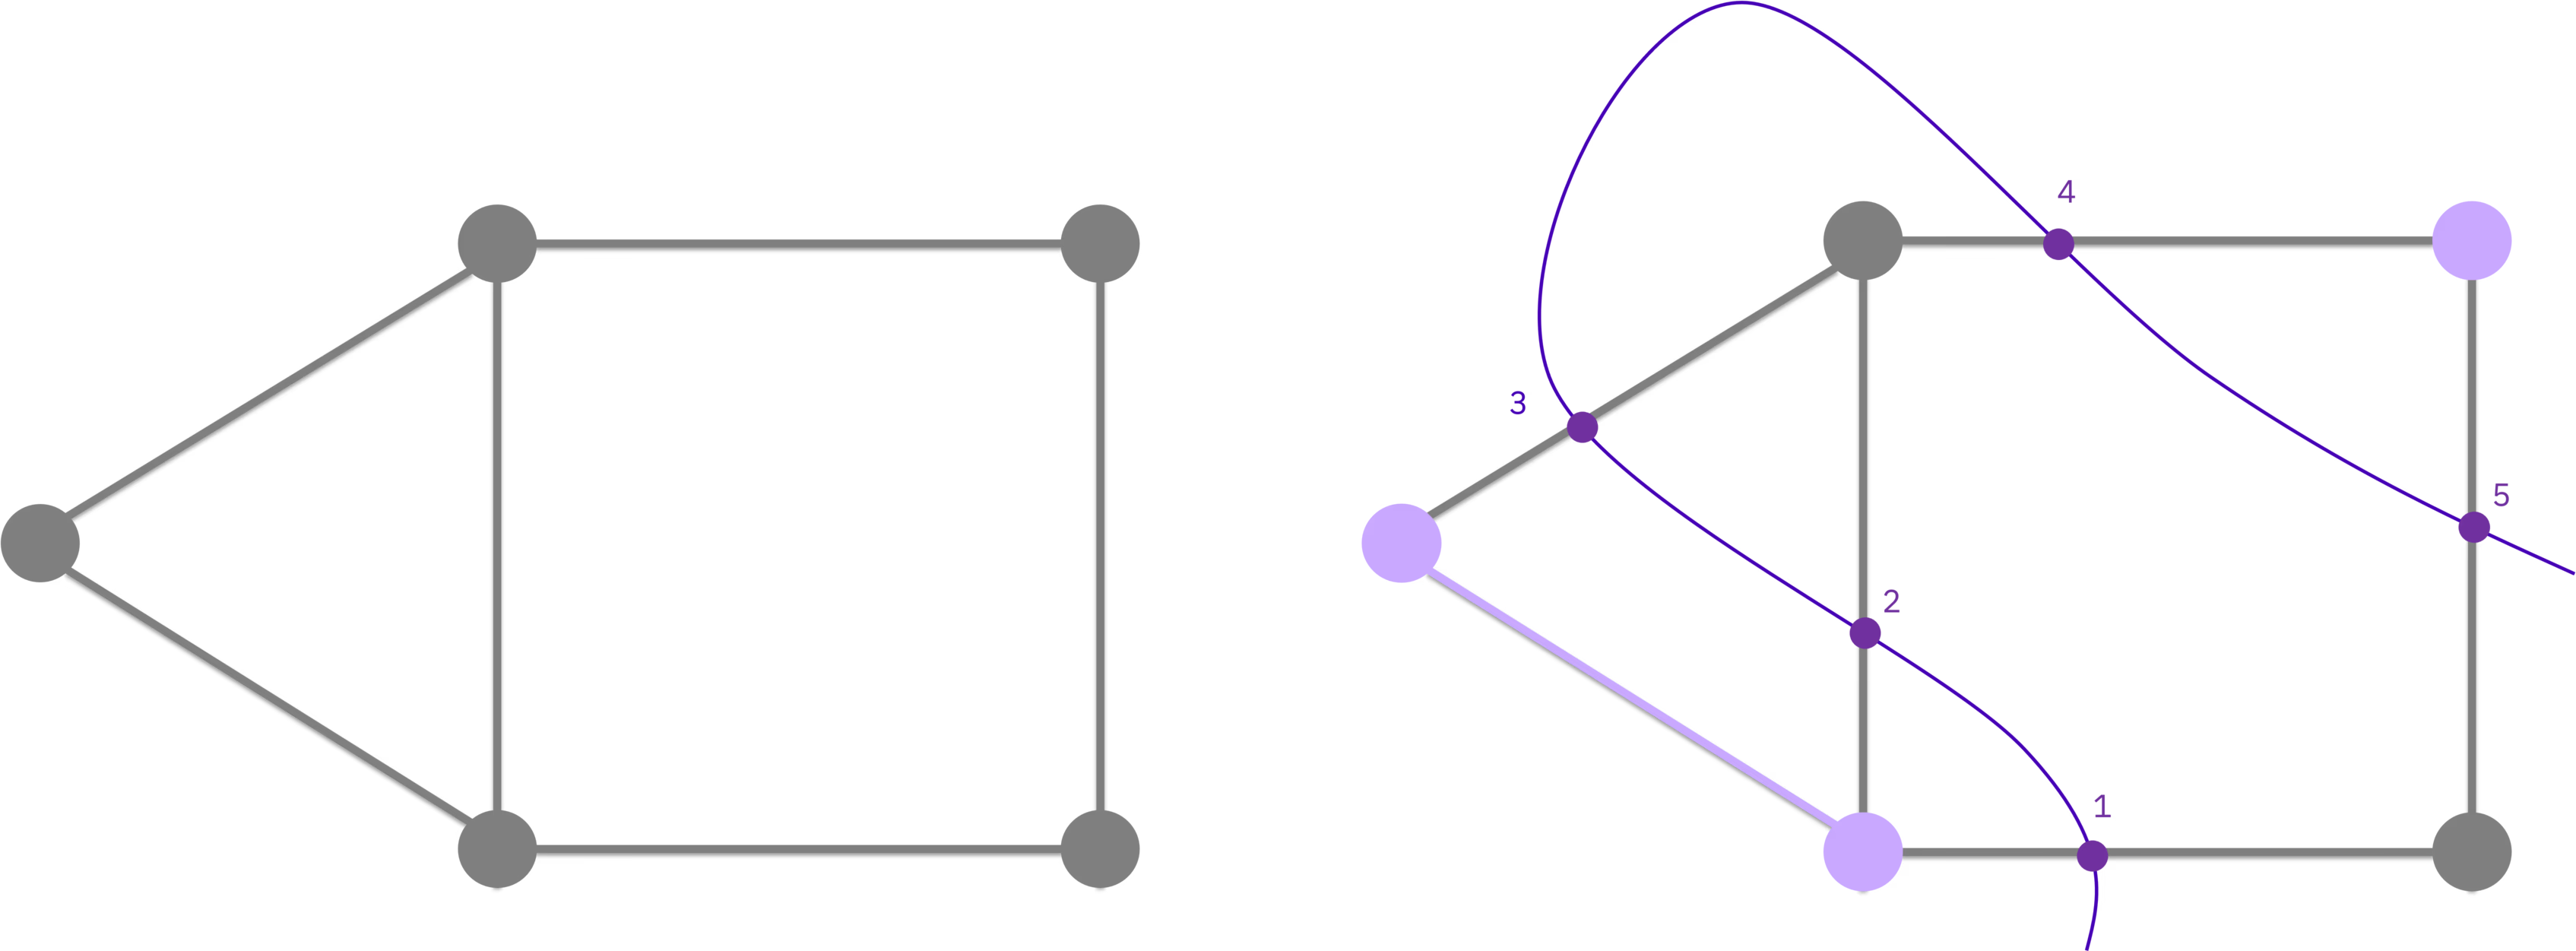

The Max-Cut problem can be mathematically represented as

$$
\max_{x \in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2x_i x_j,
$$

where $i$ and $j$ are the nodes of the graph, and $x_i$ and $x_j$ take as values $0$ or $1$ (i.e. are binary variables) depending on which side of the partition each node is on.

* If $x_i$ and $x_j$ are in the same side of the partition, the expression in the sum is zero.
* If $x_i$ and $x_j$ are in opposite sides, the expression is equal to one.

Then, maximizing the number of cuts will maximize the sum. We can equivalently write the problem as a minimization problem as

$$
\min_{x \in \{0,1\}^n} \sum_{(i,j)} 2x_i x_j - x_i - x_j
$$

More generally, this problem correspond to an example of a **Quadratic Unconstrained Binary Optimization** (QUBO) problem, which can be written in compact form as

$$
\min_{x \in \{0,1\}^n} x^T Qx
$$

where $Q$ is an $n \times n$ matrix of real numbers, and $n$ corresponds to the number of nodes in our graph. It can be shown that there exists a **one-to-one correspondence** between the $Q$ matrix of the QUBO problem and an Ising Hamiltonian, which will correspond for our purposes to the cost Hamiltonian used by QAOA:


$$
H_{C}=\sum_{i j} Q_{i j} Z_{i} Z_{j}+\sum_{i} b_{i} Z_{i}, \quad b_{i}=-\sum_{j} ( Q_{i j}+Q_{j i} ) . 
$$


The goal now will be to use QAOA to solve the Max-Cut problem for a $4$ node graph using a real QPU. We will first run the algorithm using the equivalent fake backend `FakeSherbrooke` or `FakeBrisbane`.

## Fake Backend QAOA

In [ ]:
# Let us draw the graph, using the rustworkx library

import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# Number of nodes, which for the MaxCut problem also is the number of qubits
n = 4

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 2, 1.0), (0, 1, 1.0), (2, 3, 1.0), (3, 1, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to cost Hamiltonian.
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

To construct the unitary operations required for the QAOA ansatz, we use the predefined `QAOAAnsatz` circuit.

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

# Lets consider two layers, which will correspond to four parameters
p = 2

qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
qaoa_circuit.measure_all()
print(qaoa_circuit.num_parameters)

qaoa_circuit.decompose(reps=0).draw('mpl')

Following what we learned from Qiskit Primitives, we need to transform the circuit into a ISA circuit and the cost Hamiltonian into an ISA observable.

In [ ]:
from qiskit_ibm_runtime.fake_provider import  FakeBrisbane, FakeSherbrooke

# Choose the correct fake backend depending on the least busy backend defined above!

backend_fake = FakeBrisbane()
#backend_fake = FakeSherbrooke()

pm_qaoa = generate_preset_pass_manager(backend=backend_fake, optimization_level=3)


qaoa_circuit_trans = pm_qaoa.run(qaoa_circuit)
qaoa_circuit_trans.decompose(reps=0).draw('mpl', fold=-1, idle_wires=False)  # Draw only non-idle wires

In [ ]:
cost_hamiltonian_isa = cost_hamiltonian.apply_layout(layout=qaoa_circuit_trans.layout)
cost_hamiltonian_isa

Define the initial parameters for the hybrid optimization loop, and the cost function required for the classical optimization method.

In [ ]:
initial_gamma = 4                       # We will start from a good initial guess, to speed up the optimization
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    job = estimator.run(pubs=[pub])
    result = job.result()
    energy = result[0].data.evs[0]

    # The following lines are used to keep track of the cost function history

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"].append(params)
    cost_history_dict["cost_history"].append(energy)

    print(cost_history_dict["iters"])

    return energy

# Auxiliary dictionary to keep track of the cost function and parameters history

cost_history_dict = {
    "prev_vector": [],
    "iters": 0,
    "cost_history": [],
}

In [ ]:
from scipy.optimize import minimize
from qiskit_ibm_runtime import EstimatorV2 as EstimatorRuntime

# Set mode=backend to use real QPU, otherwise mode=backend_aer to use simulator
estimator_fake = EstimatorRuntime(mode=backend_fake)


result_fake = minimize(
        cost_func,
        init_params,
        args=(qaoa_circuit_trans, cost_hamiltonian_isa, estimator_fake),
        method="COBYLA",
        tol=1e-2,
        options={"maxiter": 40},
    )

In [ ]:
# Save the results from the auxiliary dictionary

cost_history_dict_fake = cost_history_dict.copy()

result_fake

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(cost_history_dict_fake["cost_history"], label="Cost function")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.grid()
plt.legend()
plt.draw()

The algorithm looks for the optimal parameters, such that the cost function $F_p(\boldsymbol{\gamma},\boldsymbol{\beta})$ is minimized. Nonetheless, the solution to the optimization problem is encoded in the state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$, so we have to measure it to get the required information that represents the optimal cut.

In [ ]:
# Get optimal parameters

cost_history_dict_fake["prev_vector"][-1]

In [ ]:
# Assign optimal parameters to the parametrized circuit

optimized_circuit_fake = qaoa_circuit_trans.assign_parameters(cost_history_dict_fake["prev_vector"][-1])
optimized_circuit_fake.draw('mpl', fold=False, idle_wires=False)

In [ ]:
sampler_qaoa_fake = SamplerRuntime(mode=backend_fake)

pub_sampler_qaoa_fake = (optimized_circuit_fake, )
job_sampler_qaoa_fake = sampler_qaoa_fake.run([pub_sampler_qaoa_fake], shots=int(1e4))

In [ ]:
# Auxiliary function to compute the final distribution of measurement results

def final_distribution(job):
    counts_int = job_sampler_qaoa_fake.result()[0].data.meas.get_int_counts()
    counts_bin = job_sampler_qaoa_fake.result()[0].data.meas.get_counts()
    shots = sum(counts_int.values())
    final_distribution_int = {key: val/shots for key, val in counts_int.items()}
    final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

    return final_distribution_int, final_distribution_bin


final_distribution_int, final_distribution_bin = final_distribution(job_sampler_qaoa_fake)
print(final_distribution_int)

The post-processing steps ahead interpret the sampling output to return a solution for your original problem. In this case, we are interested in the **bitstring with the highest probability** as this determines the optimal cut. The symmetries in the problem allow for **two possible solutions**, and the sampling process should return one of them with a slightly higher probability.

In [ ]:
# auxiliary functions to sample most likely bitstring

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

In [ ]:
# Plot all measured bitstrings, where the two most likely are highlighted in red

import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_2_values = sorted(values, reverse=True)[:2]
positions = []
for value in top_2_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:blue")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:red")
plt.show()

Finally, we can draw the the optimal cut on the original graph using the optimal bit string.

In [ ]:
# auxiliary function to draw the graph
def plot_result(G, x):
    colors = ["tab:blue" if i == 0 else "tab:red" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [ ]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)